In [21]:
import numpy as np
import pandas as pd
import os

%matplotlib inline

#user specify instrument and contract month

product=''
month=''

while True:
    inst=int(raw_input('Please input the number of the product you want to see the seasonals: 1) Brent 2) Gasoil 3) HO 4) RBOB 5) WTI: '))
    
    if inst==1:
        product='B'
        break
    elif inst==2:
        product='G'
        break   
    elif inst==3:
        product='HO'
        break      
    elif inst==4:
        product='RB'
        break       
    elif inst==5:
        product='CL'
        break       
    else:
        print 'You did not input a correct number. Please try again.'

while True:
    Mth=int(raw_input('Please input the month of the contract which you wish to evaluate in numbers from 1-12: '))
    
    if Mth==1:
        month='Jan'
        break
    elif Mth==2:
        month='Feb'
        break   
    elif Mth==3:
        month='Mar'
        break   
    elif Mth==4:
        month='Apr'
        break   
    elif Mth==5:
        month='May'
        break          
    elif Mth==6:
        month='Jun'
        break   
    elif Mth==7:
        month='Jul'
        break   
    elif Mth==8:
        month='Aug'
        break   
    elif Mth==9:
        month='Sep'
        break   
    elif Mth==10:
        month='Oct'
        break   
    elif Mth==11:
        month='Nov'
        break   
    elif Mth==12:
        month='Dec'
        break 
    else:
        print 'You did not input a correct number. Please try again.'
        

Please input the number of the product you want to see the seasonals: 1) Brent 2) Gasoil 3) HO 4) RBOB 5) WTI: 5
Please input the month of the contract which you wish to evaluate in numbers from 1-12: 3


In [22]:
cd Quandl

C:\Users\boonsin.teo\Documents\Quandl


In [23]:
cd $product

C:\Users\boonsin.teo\Documents\Quandl\CL


In [24]:
cd $month

C:\Users\boonsin.teo\Documents\Quandl\CL\Mar


Please input start mth of seasonal period in MM format: 03
Please input start day of seasonal period in DD format: 01
Please input 1 if seasonal period starts on same year as contract year and 0 if not: 0
Please input end mth of seasonal period in MM format: 02
Please input end day of seasonal period in DD format: 28
Please input 1 if seasonal period ends on same year as contract year and 0 if not: 1
Please input the contract year seasonal index to overlay overall seasonal index with: 2018


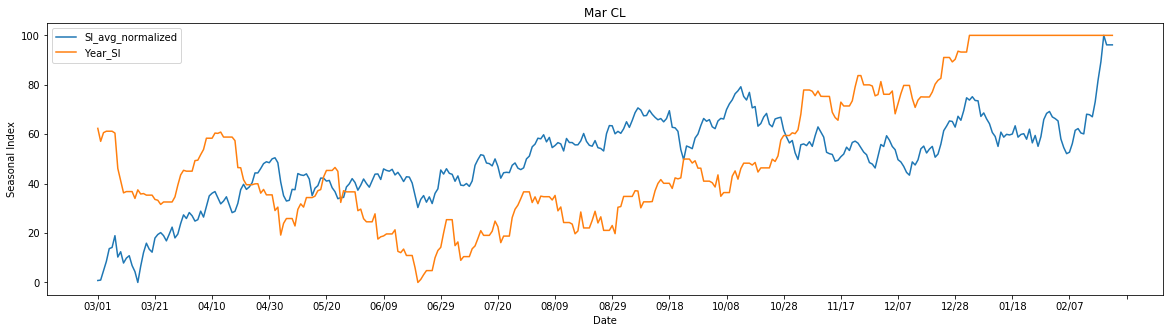

In [25]:

count=0
path = os.getcwd()

start_mth=raw_input('Please input start mth of seasonal period in MM format: ')
start_day=raw_input('Please input start day of seasonal period in DD format: ')
i=int(raw_input('Please input 1 if seasonal period starts on same year as contract year and 0 if not: '))

end_mth=raw_input('Please input end mth of seasonal period in MM format: ')
end_day=raw_input('Please input end day of seasonal period in DD format: ')
j=int(raw_input('Please input 1 if seasonal period ends on same year as contract year and 0 if not: '))            

listing = os.listdir(path)
for infile in listing:
    temp=pd.read_excel(infile) #read each file into panda dataframe
    
    contract_yr_str=infile[-8:-4] # get the contract year
    
    seasonal_year=int(contract_yr_str)-1 # get the seasonal year to create the index - prev year
    seasonal_year=str(seasonal_year) # convert to string
    
    start_date=str(int(seasonal_year)+i)+'-'+start_mth+'-'+start_day # create start date
    end_date=str(int(seasonal_year)+j)+'-'+end_mth+'-'+end_day # create end date
    
    dates=pd.date_range(start_date, end_date) # range of dates for date axis
    dates=dates.strftime('%Y-%m-%d') #make sure no left out dates
    sample_data=np.arange(0,len(dates)) #just sample numbers to create dataframe
    
    dates_dataframe=pd.DataFrame({'Date':dates,'data':sample_data}) # create dates dataframe
    dates_dataframe=dates_dataframe.set_index('Date') # set index as Date to facilitate joining
    
    temp=temp.set_index('Date') # set index as Date to facilitate joining
    
    temp=dates_dataframe.join(temp) # join dataframes together on Date
   

    temp.reset_index(inplace=True)
    
    temp=temp[temp['Date']>=start_date] # filter for start date

    temp=temp[temp['Date']<=end_date] # filter for end date
 

    temp=temp.set_index('Date') # creating new index as Date
    
    
    temp=temp.reset_index() # putting date back out into col
    temp['Date']=pd.to_datetime(temp['Date']).dt.strftime('%m/%d')
    temp=temp.set_index('Date')
    
    upper=temp['Settle'].max() # get max value
    lower=temp['Settle'].min() # get min value
    
    temp['SI']=((temp['Settle']-lower)/(upper-lower))*100 # create seasonal index column

    temp=pd.DataFrame(temp['SI'],columns=['SI']) 
    

    #combine into seasonal index table
    
    if count==0:
        Seasonal_Combi=temp
        seasonal_year=str(int(seasonal_year)+1)
        Seasonal_Combi.columns=[seasonal_year]
        
        count+=1
        
    else:
        
        seasonal_year=str(int(seasonal_year)+1)
        Seasonal_Combi[seasonal_year]=temp['SI']


#remove columns that are all NA
Seasonal_Combi.dropna(axis=1,how='all',inplace=True)

#remove rows that are all NA
Seasonal_Combi.dropna(axis=0,how='all',inplace=True)

#fillna values with values of forward value
Seasonal_Combi.fillna(method='bfill',inplace=True)
#fillna values with values of back value
Seasonal_Combi.fillna(method='ffill',inplace=True)

      
#row-wise average    
Seasonal_Combi['SI_avg']=Seasonal_Combi.mean(axis=1)

#normalize the seasonal index

upper_sc=Seasonal_Combi['SI_avg'].max()
lower_sc=Seasonal_Combi['SI_avg'].min()
Seasonal_Combi['SI_avg_normalized']=((Seasonal_Combi['SI_avg']-lower_sc)/(upper_sc-lower_sc))*100
#Seasonal_Combi['SI_avg_rolling']=Seasonal_Combi['SI_avg_normalized'].rolling(5).mean() #take a 5-day rolling average to smmooth this out

#plot on line chart

#plot on line chart
year_str=raw_input('Please input the contract year seasonal index to overlay overall seasonal index with: ')
Seasonal_Combi['Year_SI']=((Seasonal_Combi[year_str]-Seasonal_Combi[year_str].min())/(Seasonal_Combi[year_str].max()-Seasonal_Combi[year_str].min()))*100


ax=Seasonal_Combi.plot.line(y=['SI_avg_normalized','Year_SI'],figsize=(20,5),xticks=[x for x in range(0,365,20)],title=month+" "+product)
ax.set_xlabel('Date')
ax.set_ylabel('Seasonal Index')
ax.legend(loc=2)


In [26]:
cd ..

C:\Users\boonsin.teo\Documents\Quandl\CL


In [27]:
cd ..

C:\Users\boonsin.teo\Documents\Quandl


In [28]:
cd ..

C:\Users\boonsin.teo\Documents


In [29]:
pwd

u'C:\\Users\\boonsin.teo\\Documents'

In [30]:
Seasonal_Combi['Year_SI']

Date
03/01     62.355658
03/02     57.101617
03/03     60.623557
03/04     61.200924
03/05     61.200924
03/06     61.200924
03/07     60.450346
03/08     46.131640
03/09     41.166282
03/10     36.258661
03/11     36.778291
03/12     36.778291
03/13     36.778291
03/14     34.006928
03/15     37.471132
03/16     35.796767
03/17     35.969977
03/18     35.334873
03/19     35.334873
03/20     35.334873
03/21     33.602771
03/22     33.256351
03/23     31.581986
03/24     32.563510
03/25     32.563510
03/26     32.563510
03/27     32.563510
03/28     34.642032
03/29     39.376443
03/30     43.533487
            ...    
01/24    100.000000
01/25    100.000000
01/26    100.000000
01/27    100.000000
01/28    100.000000
01/29    100.000000
01/30    100.000000
01/31    100.000000
02/01    100.000000
02/02    100.000000
02/03    100.000000
02/04    100.000000
02/05    100.000000
02/06    100.000000
02/07    100.000000
02/08    100.000000
02/09    100.000000
02/10    100.000000
02/11    100.00